In [151]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def make_poor_label(df, tool_prefix):
    # tool_prefix in {"AF", "EF", "OF"}
    return (
        (df[f"{tool_prefix}_average_pLDDT"] < 70) |
        (df[f"{tool_prefix}_TM_score"] < 0.5) |
        (df[f"{tool_prefix}_RMSD"] > 9.0) |
        (df[f"{tool_prefix}_GDT_TS"] < 50)
    ).astype(int)

In [152]:
embeddings_df = pd.read_csv("./embeddings.csv")
metadata_df1 = pd.read_csv("../evaluation/chains_evaluation_filtered_with_gdt.csv")

In [153]:
embeddings_df

,sequence_id,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,5SSZ:A,0.041698,0.082317,0.017337,-0.011511,-0.035085,0.112324,-0.028229,-0.023020,-0.021959,...,-0.006125,-0.015080,-0.028736,-0.015365,0.071466,0.034531,-0.021253,-0.044281,-0.019104,0.006675
1,7FY1:A,0.047498,0.025369,0.009100,-0.032689,0.043294,-0.014423,-0.024067,-0.161998,0.039027,...,-0.047904,0.030155,-0.008186,-0.003443,0.015064,-0.079059,-0.009469,-0.074569,0.049260,0.021386
2,7G1Q:A,0.070862,0.011154,-0.006863,-0.022787,0.028306,0.004775,-0.007784,-0.156496,0.027262,...,-0.057456,0.012036,0.008975,-0.017833,0.000690,-0.106954,-0.049073,-0.081838,0.044579,0.043472
3,7G1X:A,0.029538,-0.015357,0.009438,-0.020062,0.003761,0.016320,-0.025629,-0.113614,0.044924,...,-0.047083,0.033137,-0.024161,-0.046833,0.028594,-0.063806,-0.023561,-0.093419,0.046764,0.015743
4,7H9J:A,0.080503,-0.010999,0.064930,0.011473,0.044677,0.068076,-0.060599,-0.020509,-0.018876,...,-0.041747,0.004042,-0.009992,-0.106962,0.006102,0.031285,-0.022343,-0.027299,-0.041440,-0.051504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,9FWC:A,0.016753,0.000013,0.117039,0.009715,0.012918,-0.006572,-0.031365,-0.106783,-0.014808,...,-0.051225,-0.010409,0.063774,-0.085060,0.029770,-0.005850,0.010760,-0.053217,0.001542,-0.072770
1459,9FX5:A,-0.015200,0.094616,0.029028,-0.005583,0.007496,-0.010617,0.052864,-0.057743,0.017855,...,0.008281,-0.000009,-0.013113,-0.004962,0.028970,-0.014288,0.010970,0.069420,0.035354,-0.040685
1460,9G35:A,-0.009528,0.067932,-0.021398,0.032119,-0.025142,-0.010401,-0.075979,-0.037079,0.011097,...,-0.100129,0.018395,-0.007278,-0.024896,0.012935,0.000325,-0.019377,0.029905,-0.043913,-0.001953
1461,9IID:A,0.021642,0.069980,0.014065,-0.065714,-0.132132,0.019948,-0.071130,-0.083702,0.021212,...,-0.034138,-0.029562,-0.044261,-0.111832,0.026946,-0.016103,-0.055561,0.095822,0.022081,0.047651


In [154]:
metadata_df2 = pd.read_csv("../evaluation_families/data/chains_annotations_filtered.csv")

In [155]:
metadata_df2[["chain_id", "method_of_acquisition", "sequence_length"]]

,chain_id,method_of_acquisition,sequence_length
0,8P0E:A,X-RAY DIFFRACTION,190
1,8PX8:A,X-RAY DIFFRACTION,115
2,8B2E:A,X-RAY DIFFRACTION,143
3,8HOE:A,X-RAY DIFFRACTION,189
4,8TCE:A,X-RAY DIFFRACTION,94
...,...,...,...
1332,8G9J:A,X-RAY DIFFRACTION,223
1333,8OYV:A,X-RAY DIFFRACTION,195
1334,8TNO:A,X-RAY DIFFRACTION,282
1335,8FJE:A,X-RAY DIFFRACTION,145


In [156]:
metadata_df2.method_of_acquisition.value_counts()

method_of_acquisition
X-RAY DIFFRACTION           1116
SOLUTION NMR                 127
ELECTRON MICROSCOPY           85
SOLID-STATE NMR                4
NEUTRON DIFFRACTION            2
ELECTRON CRYSTALLOGRAPHY       2
Name: count, dtype: int64

In [157]:
metadata_df = pd.merge(
            metadata_df1,
            metadata_df2[["chain_id", "method_of_acquisition", "sequence_length"]], 
            left_on='chain_id',
            right_on='chain_id',
            how='inner'
        )
metadata_df

,pdb_id,label,chain_id,AF_average_pLDDT,OF_average_pLDDT,EF_average_pLDDT,AF_TM_score,OF_TM_score,EF_TM_score,AF_RMSD,OF_RMSD,EF_RMSD,AF_GDT_TS,OF_GDT_TS,EF_GDT_TS,method_of_acquisition,sequence_length
0,8P0E,monomer,8P0E:A,93.108947,93.535368,89.263158,0.966687,0.967459,0.982825,1.757680,1.738276,0.703625,96.603261,96.467391,97.826087,X-RAY DIFFRACTION,190
1,8PX8,monomer,8PX8:A,95.914087,95.609217,95.147826,0.995011,0.995740,0.989534,0.275844,0.253193,0.706370,100.000000,100.000000,99.318182,X-RAY DIFFRACTION,115
2,8B2E,monomer,8B2E:A,97.636503,97.136084,94.762238,0.991946,0.979414,0.990990,0.400699,0.668645,0.425292,99.822695,97.517730,99.468085,X-RAY DIFFRACTION,143
3,8HOE,monomer,8HOE:A,93.577196,79.554392,89.613757,0.988360,0.863854,0.976008,0.564870,2.354328,0.834659,98.285714,76.857143,96.714286,X-RAY DIFFRACTION,189
4,8TCE,monomer,8TCE:A,90.252128,89.159681,86.180851,0.938542,0.920785,0.920808,1.805852,2.571247,2.617893,94.827586,93.965517,93.390805,X-RAY DIFFRACTION,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,8G9J,synthetic,8G9J:A,90.586771,92.542063,89.071749,0.637726,0.984365,0.984592,6.550639,0.678841,0.674661,39.925373,97.512438,97.263682,X-RAY DIFFRACTION,223
1333,8OYV,synthetic,8OYV:A,86.604205,88.043795,82.605128,0.981296,0.979309,0.980517,0.725727,0.761958,0.734274,97.390110,96.978022,97.115385,X-RAY DIFFRACTION,195
1334,8TNO,synthetic,8TNO:A,90.392837,90.149504,87.758865,0.966437,0.966444,0.958189,1.621622,1.482032,1.525321,93.933824,92.279412,89.338235,X-RAY DIFFRACTION,282
1335,8FJE,synthetic,8FJE:A,93.426345,93.104138,88.586207,0.970529,0.965841,0.972681,0.845441,0.909988,0.804459,96.507353,95.955882,97.058824,X-RAY DIFFRACTION,145


## Merge data

In [158]:
X_embeddings = embeddings_df.drop('sequence_id', axis=1)

#metadata_df = metadata_df.copy()
metadata_df['chain_id'] = metadata_df['chain_id'].astype(str)
embeddings_df['chain_id'] = embeddings_df['sequence_id'].astype(str)

metadata_df["xray"] = metadata_df["method_of_acquisition"] == "X-RAY DIFFRACTION"
metadata_df["EF_minus_AF_TM_score"] = metadata_df["EF_TM_score"] - metadata_df["AF_TM_score"]

merged_data = pd.merge(
            metadata_df,
            embeddings_df, 
            left_on='chain_id',
            right_on='chain_id',
            how='inner'
        )

merged_data

,pdb_id,label,chain_id,AF_average_pLDDT,OF_average_pLDDT,EF_average_pLDDT,AF_TM_score,OF_TM_score,EF_TM_score,AF_RMSD,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,8P0E,monomer,8P0E:A,93.108947,93.535368,89.263158,0.966687,0.967459,0.982825,1.757680,...,-0.018924,-0.055101,-0.010038,-0.079929,-0.040604,0.023142,-0.028256,0.006632,0.010835,-0.043973
1,8PX8,monomer,8PX8:A,95.914087,95.609217,95.147826,0.995011,0.995740,0.989534,0.275844,...,-0.003862,-0.036268,-0.056777,-0.021434,0.075105,0.007325,0.011608,-0.015764,-0.016603,0.018275
2,8B2E,monomer,8B2E:A,97.636503,97.136084,94.762238,0.991946,0.979414,0.990990,0.400699,...,-0.120371,-0.012060,-0.037939,-0.037256,-0.024697,0.034764,-0.069274,-0.034956,-0.067968,-0.019934
3,8HOE,monomer,8HOE:A,93.577196,79.554392,89.613757,0.988360,0.863854,0.976008,0.564870,...,0.004794,-0.005468,-0.011793,-0.045643,-0.003415,0.048465,-0.037667,-0.041685,0.048311,0.030363
4,8TCE,monomer,8TCE:A,90.252128,89.159681,86.180851,0.938542,0.920785,0.920808,1.805852,...,-0.045217,-0.015651,-0.013003,-0.089254,0.042249,0.031570,0.010612,-0.017051,0.041658,-0.012780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,8G9J,synthetic,8G9J:A,90.586771,92.542063,89.071749,0.637726,0.984365,0.984592,6.550639,...,-0.098112,0.114060,0.092363,-0.111112,-0.112436,0.047038,-0.000830,-0.036431,0.046928,0.026370
1333,8OYV,synthetic,8OYV:A,86.604205,88.043795,82.605128,0.981296,0.979309,0.980517,0.725727,...,-0.045095,0.218035,0.082360,-0.071727,0.033196,-0.031118,-0.008822,0.015488,0.019231,-0.032048
1334,8TNO,synthetic,8TNO:A,90.392837,90.149504,87.758865,0.966437,0.966444,0.958189,1.621622,...,0.001655,-0.053243,0.000991,-0.050635,-0.062184,0.015350,-0.003545,0.025028,-0.022152,-0.063211
1335,8FJE,synthetic,8FJE:A,93.426345,93.104138,88.586207,0.970529,0.965841,0.972681,0.845441,...,-0.045988,0.127117,0.057083,-0.137953,0.075811,0.125753,-0.053419,-0.075770,-0.004380,0.033179


In [147]:
merged_data.columns[:30]

Index(['pdb_id', 'label', 'chain_id', 'AF_average_pLDDT', 'OF_average_pLDDT',
       'EF_average_pLDDT', 'AF_TM_score', 'OF_TM_score', 'EF_TM_score',
       'AF_RMSD', 'OF_RMSD', 'EF_RMSD', 'AF_GDT_TS', 'OF_GDT_TS', 'EF_GDT_TS',
       'method_of_acquisition', 'sequence_length', 'xray',
       'EF_minus_AF_TM_score', 'sequence_id', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9'],
      dtype='object')

In [159]:
category1 = pd.get_dummies(merged_data['label'], prefix='label', dtype=int)
base_features = X_embeddings.columns.tolist() + ["sequence_length", "xray"]
additional_features = ["sequence_length", "xray"]

merged_data = pd.concat([merged_data, category1], axis=1)



## LightGBM training

In [167]:
what = "AF"
pLDDT = False

if pLDDT:
    X = merged_data[X_embeddings.columns.tolist() + category1.columns.tolist() + additional_features + [f"{what}_average_pLDDT"]]
else:
    X = merged_data[X_embeddings.columns.tolist() + category1.columns.tolist() + additional_features]

target_variable = f"{what}_TM_score"
y = merged_data[[target_variable]]

random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state
    )

In [172]:
model = LGBMRegressor(
        n_estimators=100,
        random_state=random_state,
        n_jobs=-1
    )

model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261373
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 1029
[LightGBM] [Info] Start training from score 0.898213


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [173]:
y_pred = model.predict(X_test)

In [174]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(0.013244034786562782, 0.5277860507100702)

In [183]:
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score

THRESH = 0.8  # binarize on TM-score threshold

# y_test is a DataFrame; make 1D arrays
y_true = y_test[target_variable].values
y_pred = np.asarray(y_pred)

# "Positive" class = low quality (TM < THRESH)
y_true_bin = (y_true < THRESH).astype(int)

# For ROC-AUC we need a score where higher => more likely positive.
# Since positive is "low TM", use risk score = -predicted_TM
risk_score = -y_pred

roc_auc = roc_auc_score(y_true_bin, risk_score)

# For F1 we need hard labels; classify as low-quality if predicted TM < THRESH
y_pred_bin = (y_pred < THRESH).astype(int)
f1 = f1_score(y_true_bin, y_pred_bin)

# (Optional but helpful for imbalance)
pr_auc = average_precision_score(y_true_bin, risk_score)

print("Derived metrics (from regression, threshold =", THRESH, ")")
print("ROC-AUC:", roc_auc)
print("F1:", f1)
print("PR-AUC:", pr_auc)
print("Positive rate:", y_true_bin.mean())


Derived metrics (from regression, threshold = 0.8 )
ROC-AUC: 0.8918918918918919
F1: 0.6666666666666666
PR-AUC: 0.7221453963983157
Positive rate: 0.17164179104477612


## SHAP Explainer

In [176]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

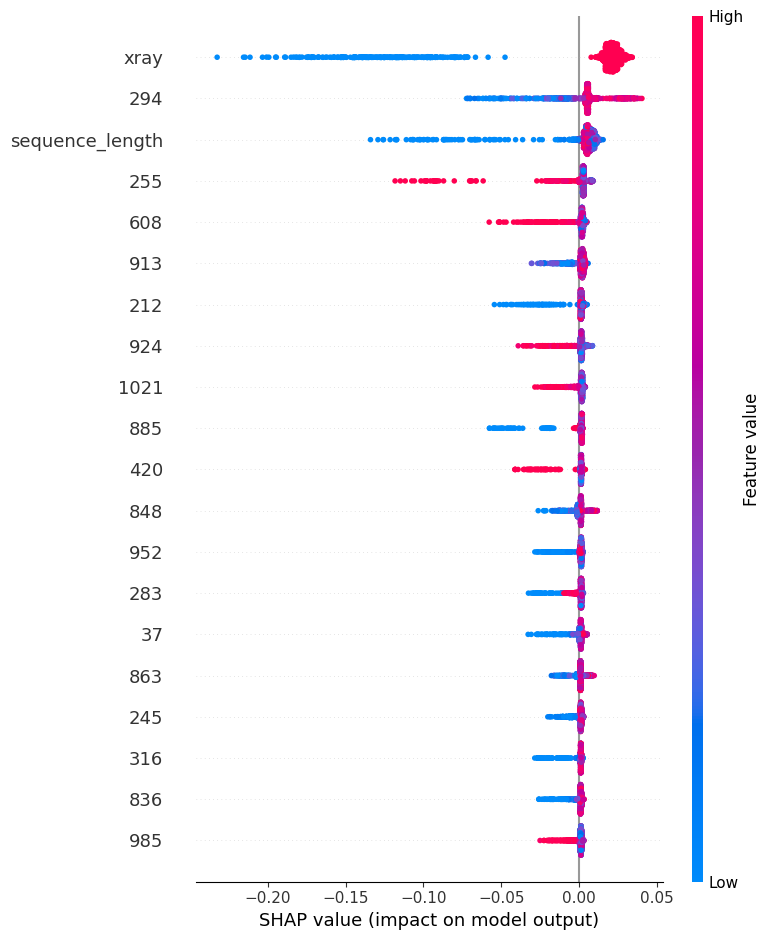

In [182]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, feature_names=X.columns, show=False, title="AF")
plt.tight_layout()

In [179]:
feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(shap_values).mean(0)
    })
feature_importance = feature_importance.sort_values('importance', ascending=False)

feature_importance.head()

,feature,importance
1028,xray,0.038917
294,294,0.010821
1027,sequence_length,0.010180
255,255,0.005487
608,608,0.003622


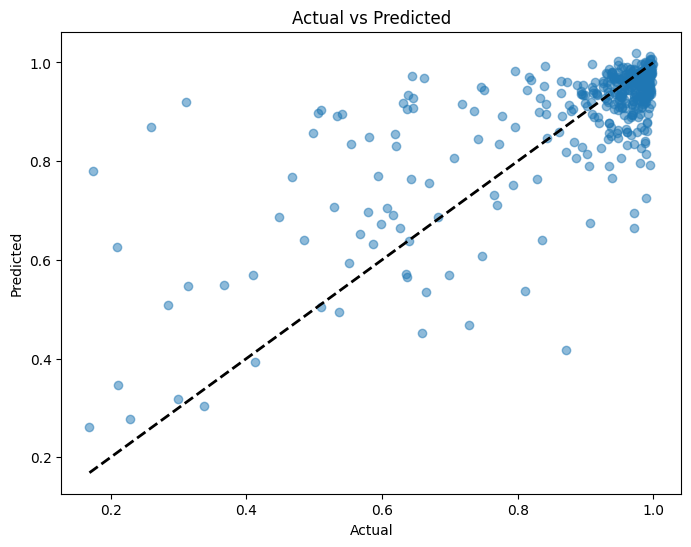

In [180]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.savefig('predictions.png')

## Save model

In [181]:
model.booster_.save_model(f"lightgbm_model_{what}_{pLDDT}.txt")

## Run all combinations

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261373
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 1029
[LightGBM] [Info] Start training from score 0.898213


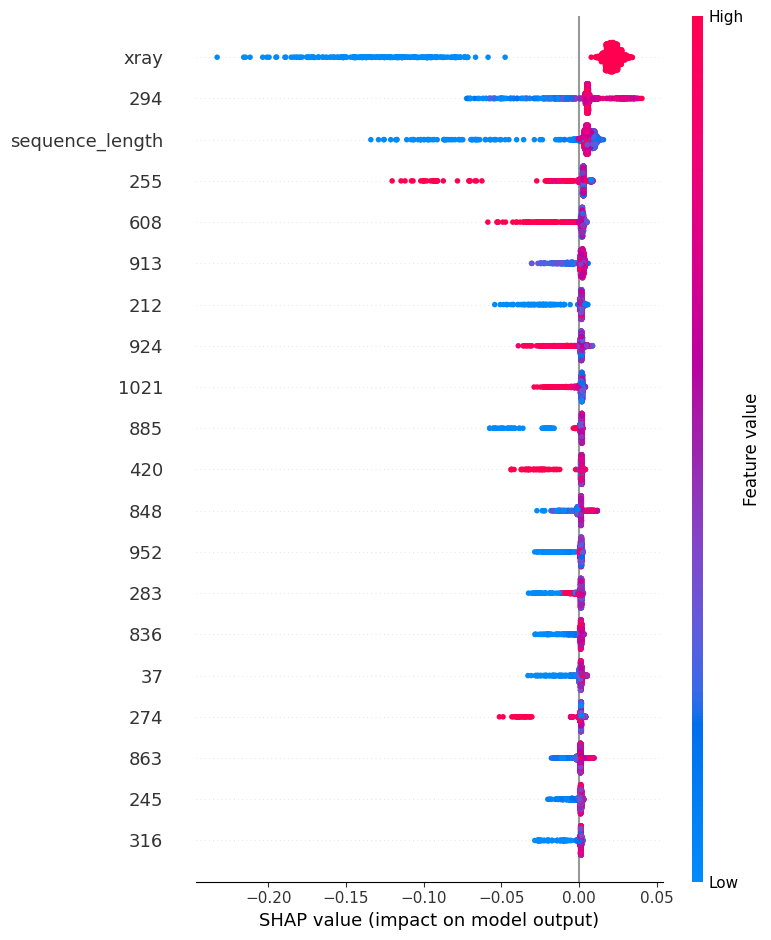

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261628
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 1030
[LightGBM] [Info] Start training from score 0.898213


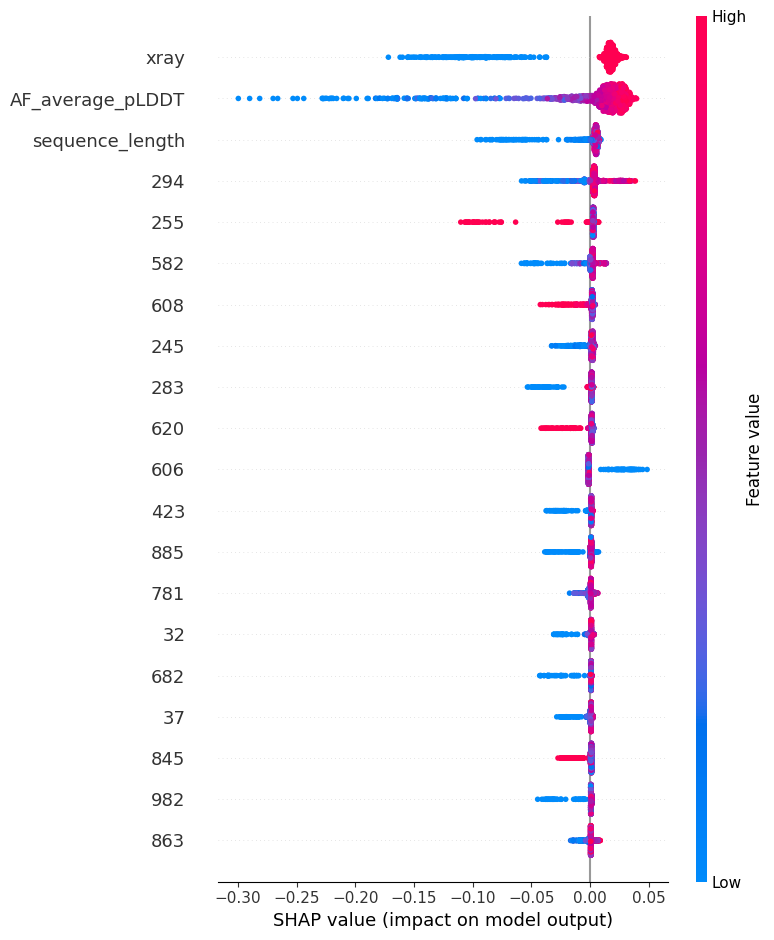

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261373
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 1029
[LightGBM] [Info] Start training from score 0.859727


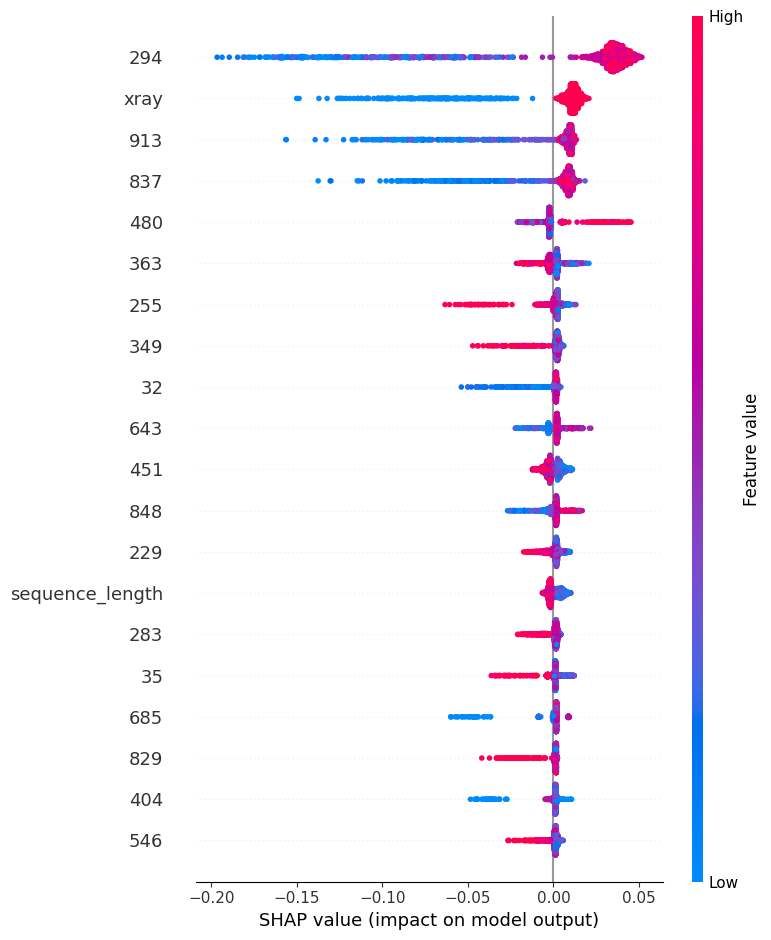

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261628
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 1030
[LightGBM] [Info] Start training from score 0.859727


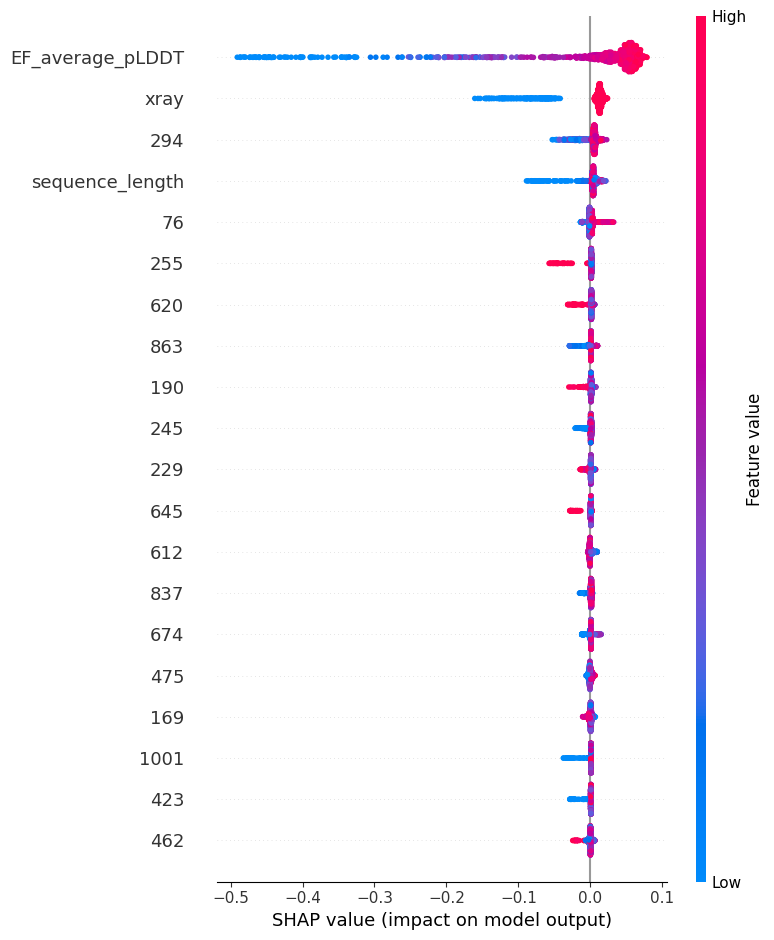

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261373
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 1029
[LightGBM] [Info] Start training from score 0.836929


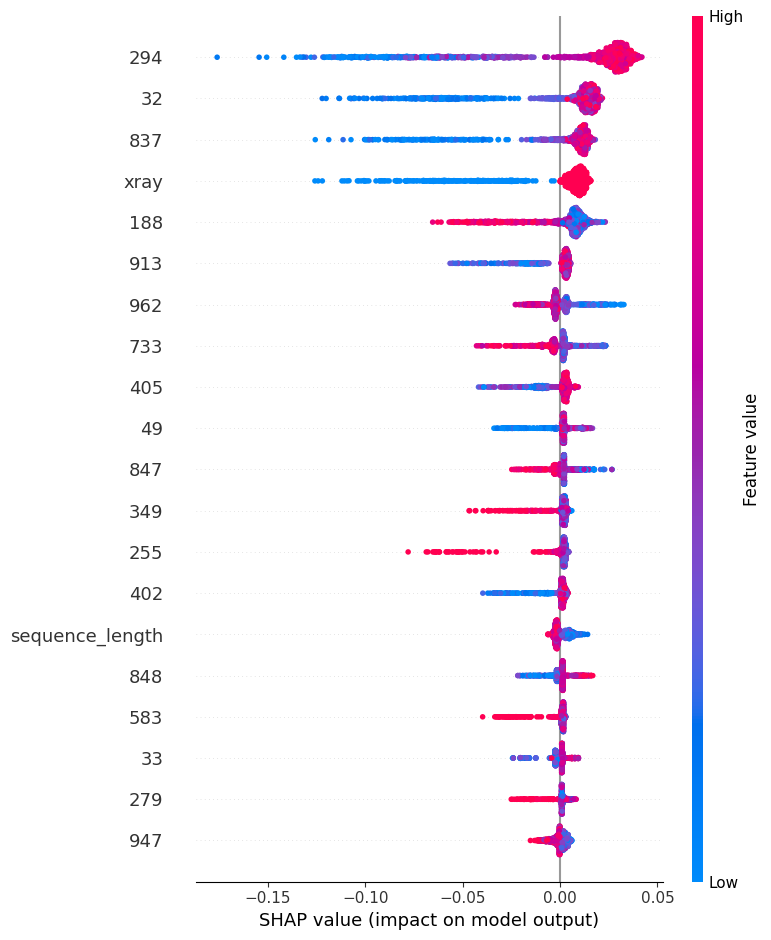

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261628
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 1030
[LightGBM] [Info] Start training from score 0.836929


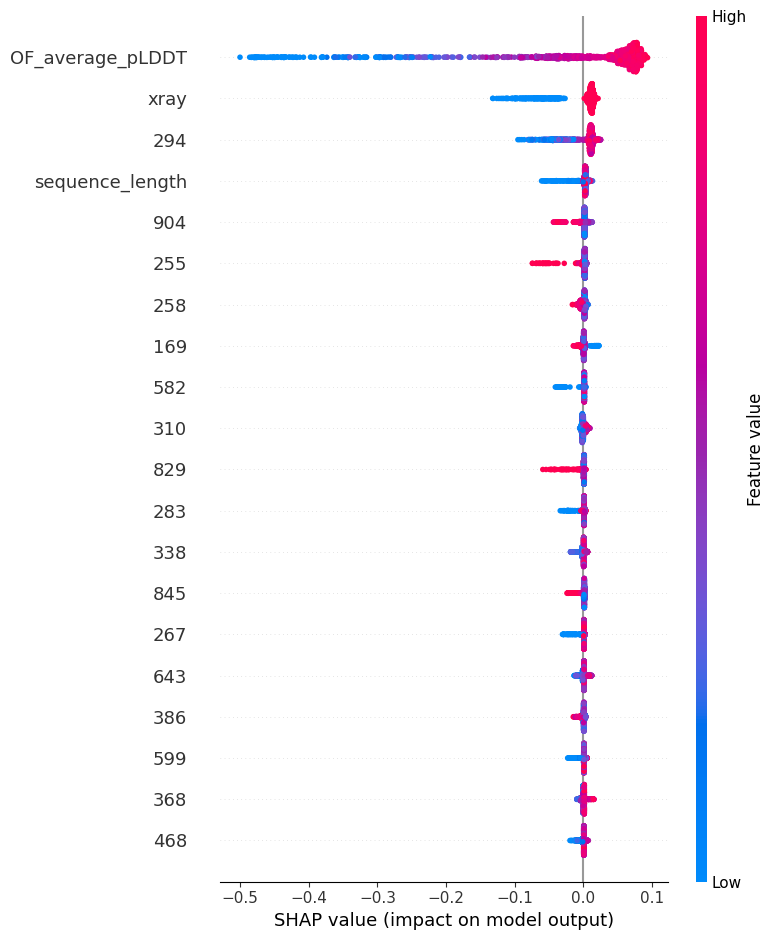

,what,use_pLDDT,target,threshold,mse,r2,roc_auc_lowTM,f1_lowTM,pr_auc_lowTM,positive_rate_lowTM,n_train,n_test,n_features,n_estimators
1,AF,True,AF_TM_score,0.8,0.010780,0.615655,0.882578,0.744186,0.753308,0.171642,935,402,1030,200
0,AF,False,AF_TM_score,0.8,0.013239,0.527961,0.885668,0.672131,0.723085,0.171642,935,402,1029,200
3,EF,True,EF_TM_score,0.8,0.010731,0.718625,0.945717,0.764706,0.862155,0.208955,935,402,1030,200
2,EF,False,EF_TM_score,0.8,0.015021,0.606146,0.931679,0.758621,0.806856,0.208955,935,402,1029,200
5,OF,True,OF_TM_score,0.8,0.011259,0.764007,0.934345,0.794393,0.889674,0.263682,935,402,1030,200
4,OF,False,OF_TM_score,0.8,0.017628,0.630514,0.918218,0.739130,0.835688,0.263682,935,402,1029,200


In [184]:
import matplotlib.pyplot as plt
import shap
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, f1_score, average_precision_score

THRESH = 0.8
TOOLS = ["AF", "EF", "OF"]
PLDDT_OPTIONS = [False, True]

all_results = []
all_feature_importance = {}   # key: (what, pLDDT) -> dataframe

def run_one(what, use_plddt, random_state=42, n_estimators=200):
    # Build X
    if use_plddt:
        X = merged_data[X_embeddings.columns.tolist() + category1.columns.tolist() + additional_features + [f"{what}_average_pLDDT"]]
    else:
        X = merged_data[X_embeddings.columns.tolist() + category1.columns.tolist() + additional_features]

    target_variable = f"{what}_TM_score"
    y = merged_data[[target_variable]]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state
    )

    # Train
    model = LGBMRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Regression metrics
    mse = mean_squared_error(y_test[target_variable].values, y_pred)
    r2 = r2_score(y_test[target_variable].values, y_pred)

    # Derived classification metrics at threshold THRESH
    y_true = y_test[target_variable].values
    y_true_bin = (y_true < THRESH).astype(int)
    risk_score = -np.asarray(y_pred)
    roc_auc = roc_auc_score(y_true_bin, risk_score)
    y_pred_bin = (np.asarray(y_pred) < THRESH).astype(int)
    f1 = f1_score(y_true_bin, y_pred_bin)
    pr_auc = average_precision_score(y_true_bin, risk_score)

    # SHAP on full X (as you do now)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, feature_names=X.columns, show=False, title=f"{what} | pLDDT={use_plddt}")
    plt.tight_layout()
    plt.show()

    # Feature importance table (mean |SHAP|)
    feature_importance = pd.DataFrame({
        "feature": X.columns,
        "mean_abs_SHAP": np.abs(shap_values).mean(axis=0),
        "mean_SHAP": shap_values.mean(axis=0),
    }).sort_values("mean_abs_SHAP", ascending=False)

    # Return everything needed
    metrics_row = {
        "what": what,
        "use_pLDDT": use_plddt,
        "target": target_variable,
        "threshold": THRESH,
        "mse": mse,
        "r2": r2,
        "roc_auc_lowTM": roc_auc,
        "f1_lowTM": f1,
        "pr_auc_lowTM": pr_auc,
        "positive_rate_lowTM": float(y_true_bin.mean()),
        "n_train": int(X_train.shape[0]),
        "n_test": int(X_test.shape[0]),
        "n_features": int(X.shape[1]),
        "n_estimators": n_estimators,
    }

    return metrics_row, feature_importance

# Run all 6 combos
for what in TOOLS:
    for use_plddt in PLDDT_OPTIONS:
        metrics_row, fi = run_one(what, use_plddt)
        all_results.append(metrics_row)
        all_feature_importance[(what, use_plddt)] = fi

results_df = pd.DataFrame(all_results).sort_values(["what", "use_pLDDT"], ascending=[True, False])
results_df


In [185]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

TOOLS = ["AF", "EF", "OF"]

def fit_and_get_shap(what, use_plddt, random_state=42, n_estimators=200):
    # Build X
    if use_plddt:
        X = merged_data[X_embeddings.columns.tolist() + category1.columns.tolist() + additional_features + [f"{what}_average_pLDDT"]]
    else:
        X = merged_data[X_embeddings.columns.tolist() + category1.columns.tolist() + additional_features]

    y = merged_data[f"{what}_TM_score"]

    # Fit (you can also fit on full data if you prefer for SHAP visuals; staying consistent with your pipeline)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state
    )

    model = LGBMRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # SHAP on full X (as you do now)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    return X, shap_values

shap_cache = {}  # (what, use_plddt) -> (X, shap_values)

for use_plddt in [False, True]:
    for what in TOOLS:
        X, sv = fit_and_get_shap(what, use_plddt)
        shap_cache[(what, use_plddt)] = (X, sv)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261373
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 1029
[LightGBM] [Info] Start training from score 0.898213
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261373
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 1029
[LightGBM] [Info] Start training from score 0.859727
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261373
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 1029
[LightGBM] [Info] Sta

In [214]:
import matplotlib
matplotlib.use("Agg")  # PNG-only backend

import matplotlib.pyplot as plt
import shap
import os

TOOLS = ["AF", "EF", "OF"]

def save_shap_panel_png(
    what,
    use_plddt,
    out_png,
    max_display=20,
    dpi=300,
    fig_w=6,
    fig_h=6
):
    X, sv = shap_cache[(what, use_plddt)]

    # Only keep the colorbar for OF
    keep_cbar = (what == "OF")

    shap.summary_plot(
        sv, X,
        plot_type="dot",
        max_display=max_display,
        show=False,
        color_bar=keep_cbar
    )

    ax = plt.gca()
    full_names = {'AF': 'AlphaFold2', 'EF': 'ESMFold', 'OF': 'OmegaFold'}
    ax.set_title(full_names[what], fontsize=14, pad=10)

    fig = plt.gcf()
    fig.set_size_inches(fig_w, fig_h)

    fig.savefig(out_png, dpi=dpi, bbox_inches="tight")
    plt.close(fig)

def save_three_shap_panels(use_plddt, out_dir="shap_panels", max_display=20, dpi=300):
    os.makedirs(out_dir, exist_ok=True)
    paths = []
    for what in TOOLS:
        p = os.path.join(out_dir, f"shap_{what}_pLDDT_{use_plddt}.png")
        save_shap_panel_png(what, use_plddt, p, max_display=max_display, dpi=dpi)
        paths.append(p)
    return paths

# Example:
panel_paths_false = save_three_shap_panels(use_plddt=False, out_dir="shap_panels_false", max_display=20, dpi=300)
panel_paths_true  = save_three_shap_panels(use_plddt=True,  out_dir="shap_panels_true",  max_display=20, dpi=300)

panel_paths_false, panel_paths_true

(['shap_panels_false/shap_AF_pLDDT_False.png',
  'shap_panels_false/shap_EF_pLDDT_False.png',
  'shap_panels_false/shap_OF_pLDDT_False.png'],
 ['shap_panels_true/shap_AF_pLDDT_True.png',
  'shap_panels_true/shap_EF_pLDDT_True.png',
  'shap_panels_true/shap_OF_pLDDT_True.png'])

In [215]:
from PIL import Image

def combine_pngs_1x3(png_paths, out_png, pad=20, bg=(255, 255, 255)):
    imgs = [Image.open(p).convert("RGB") for p in png_paths]

    # Make same height by padding (no scaling artifacts)
    max_h = max(im.height for im in imgs)
    padded = []
    for im in imgs:
        if im.height == max_h:
            padded.append(im)
        else:
            canvas = Image.new("RGB", (im.width, max_h), bg)
            canvas.paste(im, (0, (max_h - im.height)//2))
            padded.append(canvas)

    total_w = sum(im.width for im in padded) + pad * (len(padded) - 1)
    out = Image.new("RGB", (total_w, max_h), bg)

    x = 0
    for im in padded:
        out.paste(im, (x, 0))
        x += im.width + pad

    out.save(out_png)
    print("Saved:", out_png)

# Combine into the two final figures
combine_pngs_1x3(panel_paths_false, "Figure_SHAP_1x3_pLDDT_FALSE.png")
combine_pngs_1x3(panel_paths_true,  "Figure_SHAP_1x3_pLDDT_TRUE.png")


Saved: Figure_SHAP_1x3_pLDDT_FALSE.png
Saved: Figure_SHAP_1x3_pLDDT_TRUE.png
